In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback
from sklearn import preprocessing
from ucimlrepo import fetch_ucirepo 

import seaborn as sns

2024-08-04 18:53:43.440346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
dataset_name = "tictactoe"

In [5]:
# fetch dataset 
credit_approval = fetch_ucirepo(id=101) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 101, 'name': 'Tic-Tac-Toe Endgame', 'repository_url': 'https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame', 'data_url': 'https://archive.ics.uci.edu/static/public/101/data.csv', 'abstract': 'Binary classification task on possible configurations of tic-tac-toe game', 'area': 'Games', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 958, 'num_features': 9, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Mon Aug 19 1991', 'dataset_doi': '10.24432/C5688J', 'creators': ['David Aha'], 'intro_paper': None, 'additional_info': {'summary': 'This database encodes the complete set of possible board configurations at the end of tic-tac-toe games, where "x" is assumed to have played first.  The target concept is "win for x" (i.e., true when "x" has one of 8 possible ways to create a "three

In [6]:
categorical_cols = X.columns
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(X, columns=categorical_cols)
# Initialize a scaler
scaler = preprocessing.StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = X.fillna(0)
# to numpy
X = X.values

In [7]:
y = np.array([1.0 if elem == "positive" else 0.0 for elem in y["class"]])

In [8]:
from sklearn import model_selection

In [9]:
X, Xtest, y, ytest = model_selection.train_test_split(X, y)

In [10]:
y.mean()

0.649025069637883

In [11]:
ytest.sum()

160.0

## Specify learning algorithms

In [12]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(f"{X=}")
    #print(f"{theta.T=}")
    #print(f"{y=}")
    y = sigmoid(y)
    #print(f"{y=}")
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    #print(f"{p=}")
    #print(f"{y=}")
    #print(f"{l=}")
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + np.exp(u)) ** 2) * np.log1p(np.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [13]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 6500
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_random":
            """
            Added to address the reviewer's comment:
            The authors conduct experiments on "uniform sampling" + "constant step size", "loss-based sampling" + "constant step size", 
            and "loss-based sampling" + "Polyak step size" to verify the effectiveness of the approach of loss-based sampling. For 
            completeness, it is necessary to present the performance of using "uniform sampling" + "Polyak step size" in the numerical experiments.
            """
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = pz0
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 10 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [14]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [15]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [16]:
hyperparam_per_algo["absloss"] = {"eta": 0.05}
hyperparam_per_algo["random"] = {"eta": 0.05}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.05,
    "kappa": 1.5,
    "kappa0": 0.99,
    "omega": 1.0
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.05,
    "kappa": 1.5,
    "kappa0": 0.99,
    "omega": 1.0
}

In [17]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 1.5, 'kappa0': 0.99, 'eta': 0.05, 'omega': 1.0},
 'polyak_exponent': {'kappa': 1.5,
  'kappa0': 0.99,
  'eta': 0.05,
  'polyakexp': 0.9951814804061615,
  'omega': 1.0},
 'absloss': {'eta': 0.05},
 'random': {'eta': 0.05}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [18]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 718 iterations with d=27
loss: 0.6731609652495306, train loss: 0.6931471805599453, ||theta||_1: 0.6082286991153387 acc: 0.5
loss: 0.6658065304541415, train loss: 0.5124830507030232, ||theta||_1: 0.9283856443692279 acc: 1.0
loss: 0.6494515362950408, train loss: 0.4635546798026095, ||theta||_1: 1.5403325470044682 acc: 1.0
loss: 0.6745401255603997, train loss: 0.5767970160698408, ||theta||_1: 2.1774260340442657 acc: 1.0
loss: 0.6678857516196385, train loss: 0.5890607573794473, ||theta||_1: 2.501611540352995 acc: 1.0
loss: 0.6583467416947528, train loss: 0.4655086997031945, ||theta||_1: 2.49433804987909 acc: 1.0
loss: 0.6622064122728273, train loss: 0.8935377850750262, ||theta||_1: 2.388020846502215 acc: 0.0
loss: 0.6742651626416125, train loss: 0.5308664290966765, ||theta||_1: 2.372969856816965 acc: 1.0
loss: 0.6750891267479077, train loss: 0.5133997355975309, ||theta||_1: 2.757551807800672 acc: 1.0
loss: 0.6598346625499146, train loss: 0.6496896153109626,

In [19]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [20]:
absloss_mean_sampling_prob

0.4186530179089103

In [21]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 718 iterations with d=27
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.7124079338729761, train loss: 0.4773291609007266, ||theta||_1: 1.1473839711087934 acc: 1.0
loss: 0.7148910463505879, train loss: 0.4685697752372793, ||theta||_1: 1.4967216549264977 acc: 1.0
loss: 0.7101281545777163, train loss: 0.9516833184731126, ||theta||_1: 1.6635131055377048 acc: 0.0
loss: 0.7263025859952542, train loss: 0.954753606160903, ||theta||_1: 1.7892305561647284 acc: 0.0
loss: 0.70209443246968, train loss: 0.25564111789021987, ||theta||_1: 2.4079687508687626 acc: 1.0
loss: 0.6908450942446055, train loss: 0.3955511549771782, ||theta||_1: 2.5068930605505666 acc: 1.0
loss: 0.7056264288771559, train loss: 0.7148964701732983, ||theta||_1: 2.7261563453596205 acc: 0.0
loss: 0.6914247791293511, train loss: 0.2639032001385103, ||theta||_1: 3.078616848675209 acc: 1.0
loss: 0.6865172341699055, train loss: 0.4832922780433735, ||theta||_1:

In [22]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 718 iterations with d=27
loss: 0.6731609652495306, train loss: 0.6931471805599453, ||theta||_1: 0.6082286991153387 acc: 0.5
loss: 0.6463498191817268, train loss: 0.38719096896944205, ||theta||_1: 1.4237083321832653 acc: 1.0
loss: 0.6491317602004986, train loss: 0.4021379713308576, ||theta||_1: 2.2373070540232916 acc: 1.0
loss: 0.6576274304616313, train loss: 0.2113437773838391, ||theta||_1: 2.451043815142498 acc: 1.0
loss: 0.6516987924503808, train loss: 0.4115274777752958, ||theta||_1: 2.7588686142591614 acc: 1.0
loss: 0.6620013596119018, train loss: 0.7696387794838351, ||theta||_1: 2.57740947147359 acc: 0.0
loss: 0.6733212313256336, train loss: 0.5077339675806287, ||theta||_1: 2.96359567903609 acc: 1.0
loss: 0.6671067934951256, train loss: 0.486926190922496, ||theta||_1: 3.042346433992238 acc: 1.0
loss: 0.6638660516809683, train loss: 0.2414122801371244, ||theta||_1: 3.0821715161443777 acc: 1.0
loss: 0.6342920884198108, train loss: 0.7258767117105465, 

In [23]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 718 iterations with d=27
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6780041726104205, train loss: 0.6662722893113197, ||theta||_1: 0.5880375145778601 acc: 1.0
loss: 0.6779431298509166, train loss: 0.5545142172136395, ||theta||_1: 1.2025642312644256 acc: 1.0
loss: 0.6645994572409986, train loss: 0.357415025774047, ||theta||_1: 1.6727799453588659 acc: 1.0
loss: 0.657303532104977, train loss: 0.5143682638515247, ||theta||_1: 2.10657521868551 acc: 1.0
loss: 0.6705815952990541, train loss: 0.5979843121146516, ||theta||_1: 2.7269363877784634 acc: 1.0
loss: 0.6577554396620575, train loss: 0.8966996976518343, ||theta||_1: 2.4424943666809016 acc: 0.0
loss: 0.6613331688225343, train loss: 0.7172938108758073, ||theta||_1: 2.0593677392347014 acc: 0.0
loss: 0.6642450106422578, train loss: 0.6025219095210186, ||theta||_1: 2.249600481398845 acc: 1.0
loss: 0.6479101869594289, train loss: 0.5821585780359723, ||theta||_1: 

In [24]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

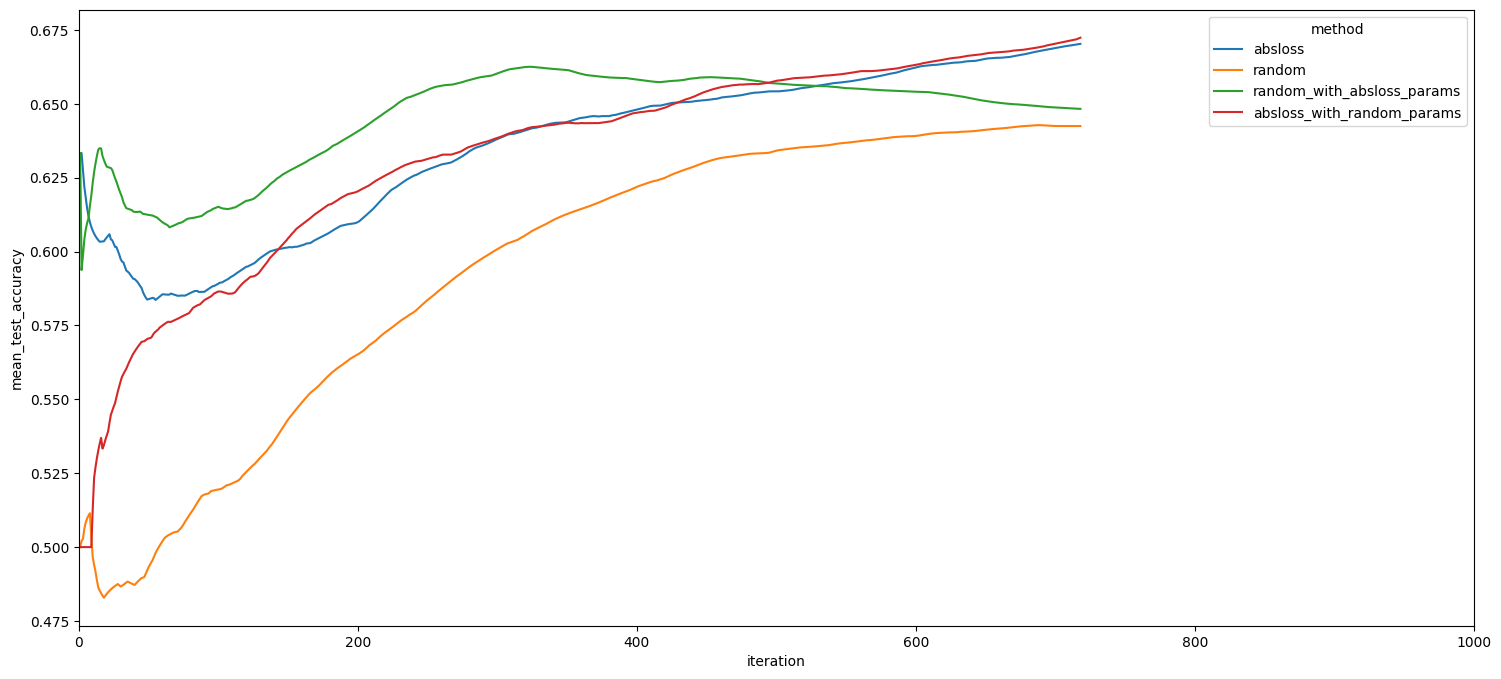

In [25]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

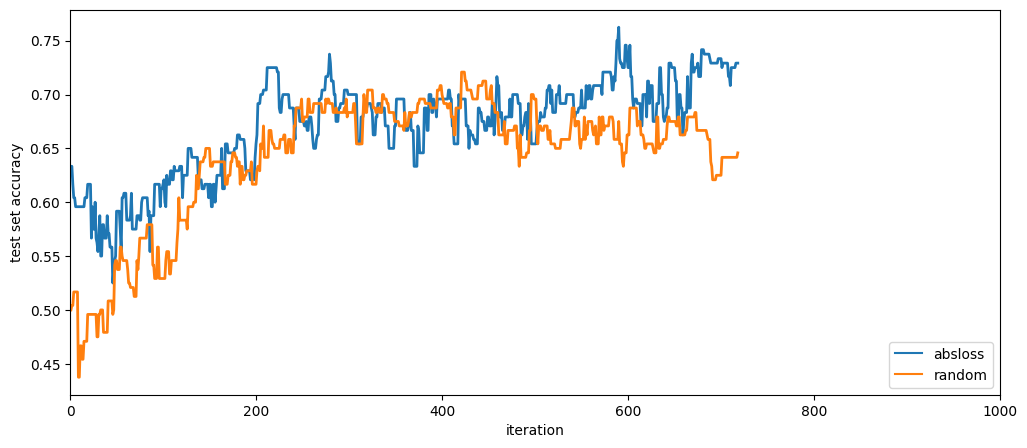

In [26]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig(f"figure_8a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

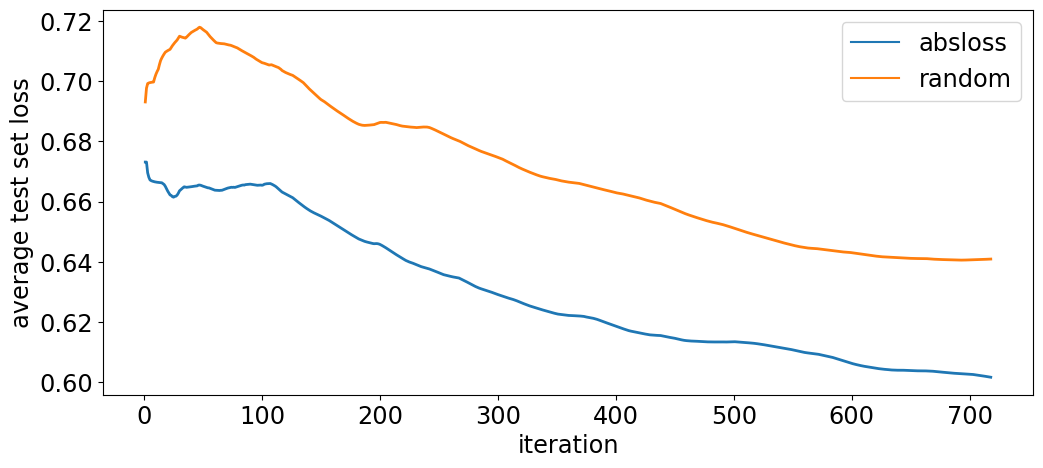

In [27]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_7a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

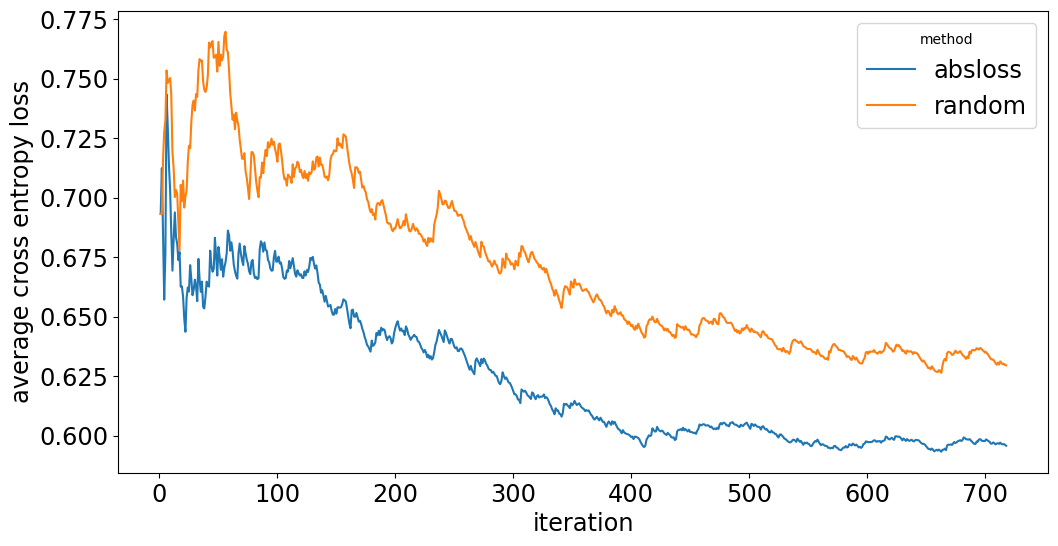

In [28]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

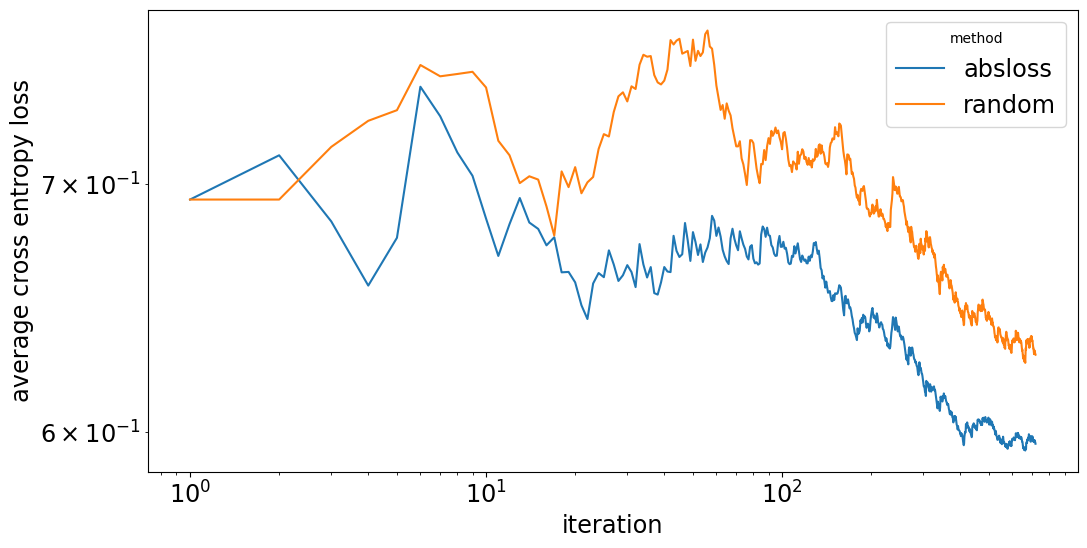

In [29]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [30]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 718 iterations with d=27
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6892851212546222, train loss: 0.6931471805599453, ||theta||_1: 0.6161892826462917 acc: 0.5
loss: 0.6925601636561548, train loss: 0.5588695729494257, ||theta||_1: 1.2441065416825088 acc: 1.0
loss: 0.6984050847370564, train loss: 0.3929391614526606, ||theta||_1: 1.3887783688568807 acc: 1.0
loss: 0.6985318421519815, train loss: 0.49054845117979196, ||theta||_1: 1.6482701671358557 acc: 1.0
loss: 0.6985318421519815, train loss: 0.5653606664757747, ||theta||_1: 1.6482701671358557 acc: 1.0
loss: 0.6893703428131764, train loss: 0.7680042996984671, ||theta||_1: 1.761075203966003 acc: 0.0
loss: 0.7004572917167907, train loss: 0.6086354329603415, ||theta||_1: 1.9928703920199247 acc: 1.0
loss: 0.70722401610243, train loss: 0.658864649659466, ||theta||_1: 2.1352661609419705 acc: 1.0
loss: 0.6958357167574235, train loss: 0.47536764887892397, ||

In [31]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[3.689604809978294, 1.844802404989147, 1.11068171994957, 0.555340859974785]

In [32]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [33]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [34]:
empirical_pzs

[0.0010712697150814176,
 0.3083920125129607,
 0.2517481768295585,
 0.42578899905585826]

In [35]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [36]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [37]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs   
polyak_exponent  0.6         0.302114    0.927399
                             0.305866    1.053787
                             0.309523    1.210976
                             0.309574    1.199388
                             0.309926    1.369838
                                           ...   
                 3.7         0.002185    0.693147
random           0.6         0.425789    0.608742
                 1.1         0.251748    0.648733
                 1.8         0.308392    0.648732
                 3.7         0.001071    0.693147
Name: train_loss, Length: 2022, dtype: float64

In [38]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs   
polyak_exponent  0.6         0.302114    0.635889
                             0.305866    0.656536
                             0.309523    0.658884
                             0.309574    0.646058
                             0.309926    0.638975
                                           ...   
                 3.7         0.002185    0.693147
random           0.6         0.425789    0.599256
                 1.1         0.251748    0.630435
                 1.8         0.308392    0.638091
                 3.7         0.001071    0.693147
Name: mean_train_loss, Length: 2022, dtype: float64

Polyak exp value 3.7 has rows (1436, 16)
Polyak exp value 1.8 has rows (1436, 16)
Polyak exp value 1.1 has rows (1436, 16)
Polyak exp value 0.6 has rows (1436, 16)


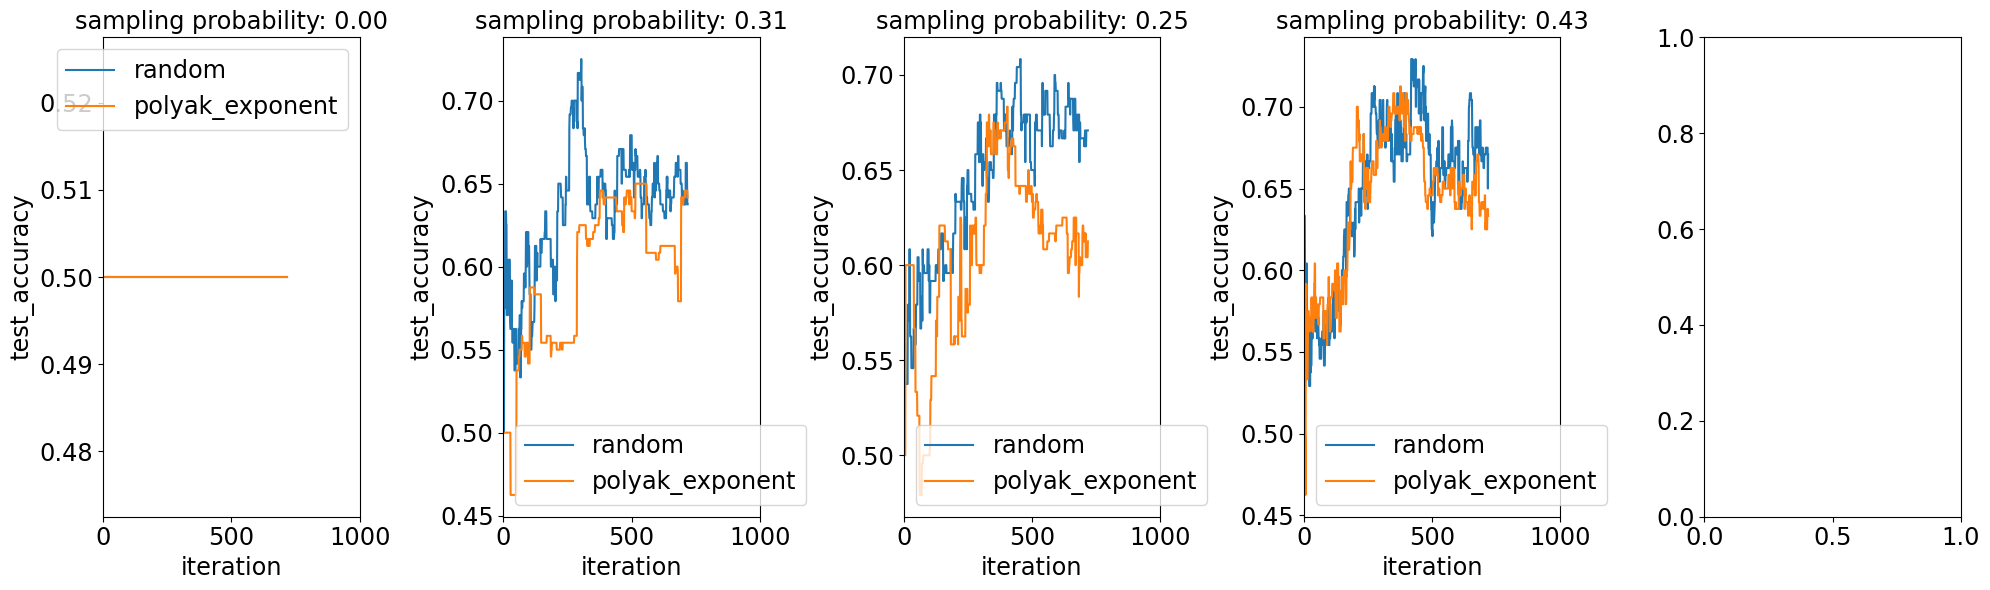

In [39]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 3.7 has rows (1436, 16)
Polyak exp value 1.8 has rows (1436, 16)
Polyak exp value 1.1 has rows (1436, 16)
Polyak exp value 0.6 has rows (1436, 16)


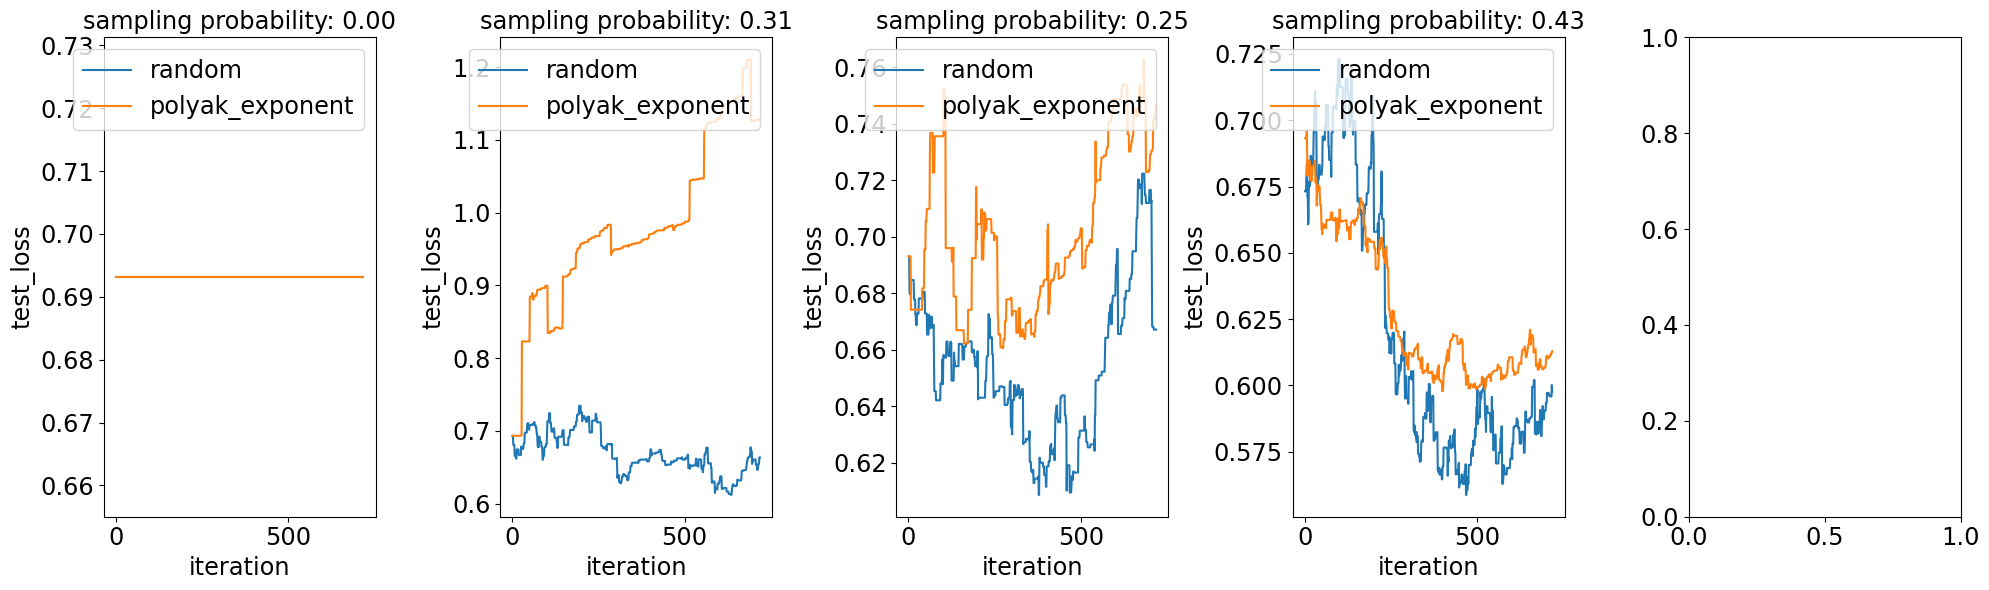

In [40]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [41]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

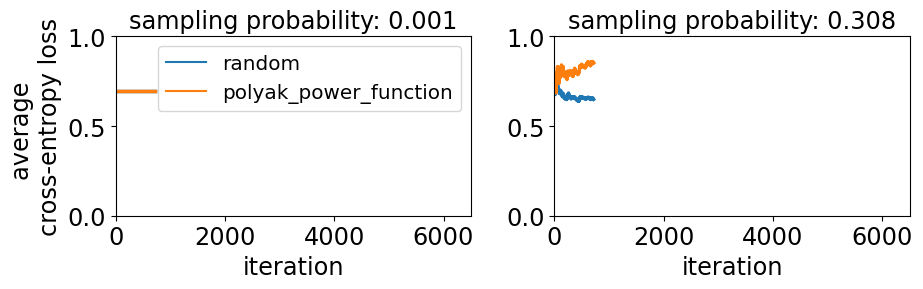

In [42]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

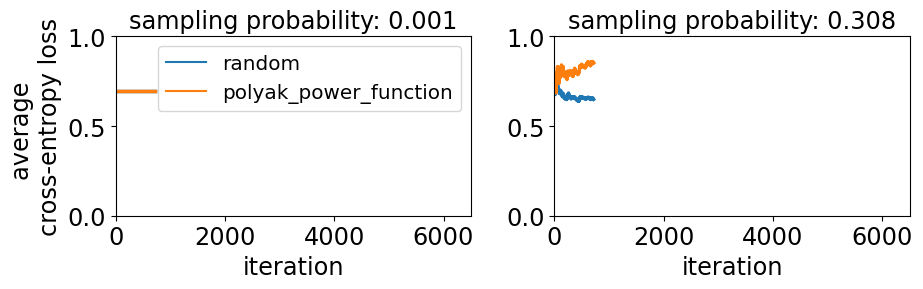

In [43]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

0.0010712697150814176
Polyak exp value 3.7 has rows (1436, 16)
0.3083920125129607
Polyak exp value 1.8 has rows (1436, 16)
0.2517481768295585
Polyak exp value 1.1 has rows (1436, 16)
0.42578899905585826
Polyak exp value 0.6 has rows (1436, 16)


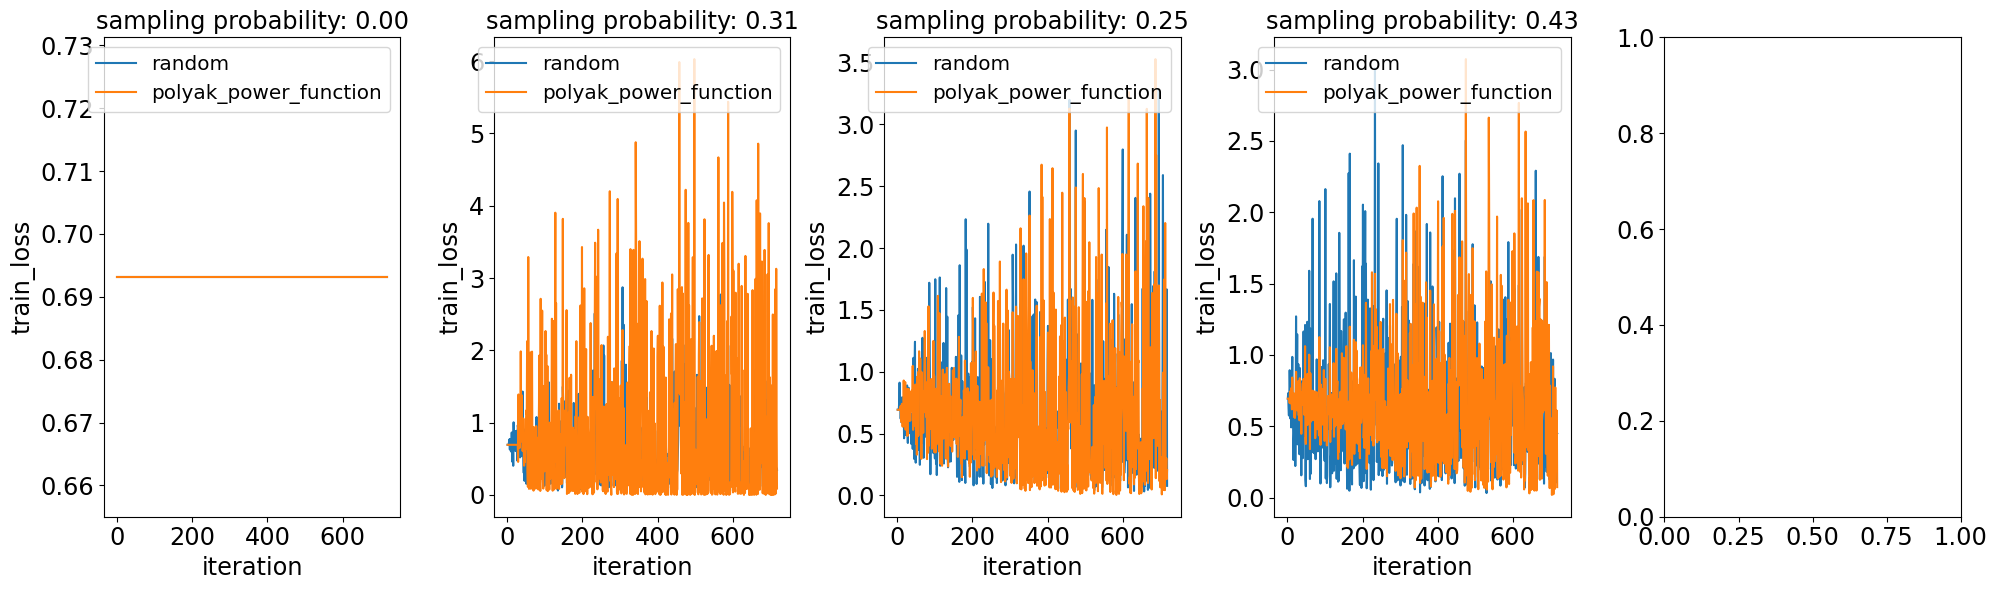

In [44]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.0010712697150814176
Polyak exp value 3.7 has rows (1436, 16)
0.3083920125129607
Polyak exp value 1.8 has rows (1436, 16)
0.2517481768295585
Polyak exp value 1.1 has rows (1436, 16)
0.42578899905585826
Polyak exp value 0.6 has rows (1436, 16)


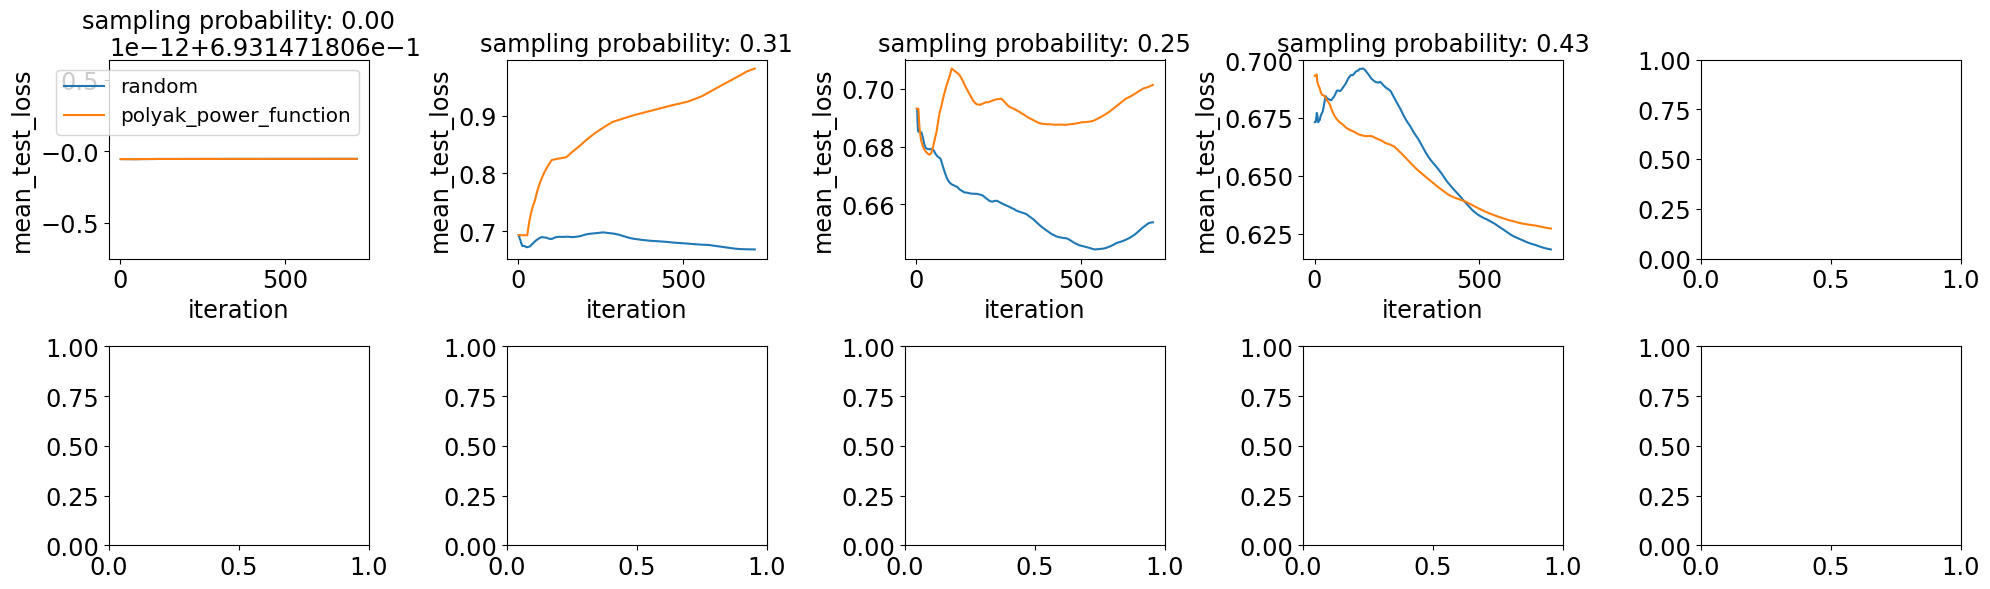

In [45]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [46]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 1.5, 'kappa0': 0.99, 'eta': 0.05, 'omega': 1.0}

In [47]:
results_polyak_random = train_model(
    X, y, Xtest, ytest, mode="polyak_random", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"] | {"pz0": absloss_mean_sampling_prob}
)

Training with algorithm polyak_random: 718 iterations with d=27
loss: 0.684389878557719, train loss: 0.6931471805599453, ||theta||_1: 0.24166384237655067 acc: 0.5
loss: 0.6767950660058297, train loss: 0.6708659034151447, ||theta||_1: 0.4341957867457094 acc: 1.0
loss: 0.6776406756367208, train loss: 0.5304098310522255, ||theta||_1: 0.7759605638790426 acc: 1.0
loss: 0.6873789682040823, train loss: 0.5890766100462307, ||theta||_1: 0.9161853638745764 acc: 1.0
loss: 0.6801431339647065, train loss: 0.5257900654012743, ||theta||_1: 1.1618452673175201 acc: 1.0
loss: 0.6747193970817738, train loss: 0.48024540634254936, ||theta||_1: 1.308194386614175 acc: 1.0
loss: 0.67858676015699, train loss: 0.9269845867948939, ||theta||_1: 1.1659306057419023 acc: 0.0
loss: 0.6735750068818577, train loss: 0.7157186037864377, ||theta||_1: 1.2592342701129287 acc: 0.0
loss: 0.6598017426622734, train loss: 0.5716659167247886, ||theta||_1: 1.396057980471451 acc: 1.0
loss: 0.664843511127513, train loss: 0.755747438

In [48]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 718 iterations with d=27
loss: 0.6857410622301906, train loss: 0.6931471805599453, ||theta||_1: 0.2023465938608123 acc: 0.5
loss: 0.6812309737439419, train loss: 0.5705870470872421, ||theta||_1: 0.41168734612415897 acc: 1.0
loss: 0.6793992493726742, train loss: 0.6127549018919549, ||theta||_1: 0.6233730926340879 acc: 1.0
loss: 0.6819063771159077, train loss: 0.5555097191647853, ||theta||_1: 0.6972354695761908 acc: 1.0
loss: 0.6902116023230686, train loss: 0.8142784802012502, ||theta||_1: 1.0346299986401677 acc: 0.0
loss: 0.682336931034765, train loss: 0.6069038845004143, ||theta||_1: 1.0830121007248543 acc: 1.0
loss: 0.6833438395908387, train loss: 0.847267057270766, ||theta||_1: 1.0272431318135797 acc: 0.0
loss: 0.6746892883026834, train loss: 0.6832886788307283, ||theta||_1: 1.1792271358972903 acc: 1.0
loss: 0.6728556226496821, train loss: 0.5356258561556763, ||theta||_1: 1.2949993684850905 acc: 1.0
loss: 0.6672558398879987, train loss: 0.62951

In [49]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 1.5, 'kappa0': 0.99, 'eta': 0.05, 'omega': 0.9691919246852252}


In [50]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

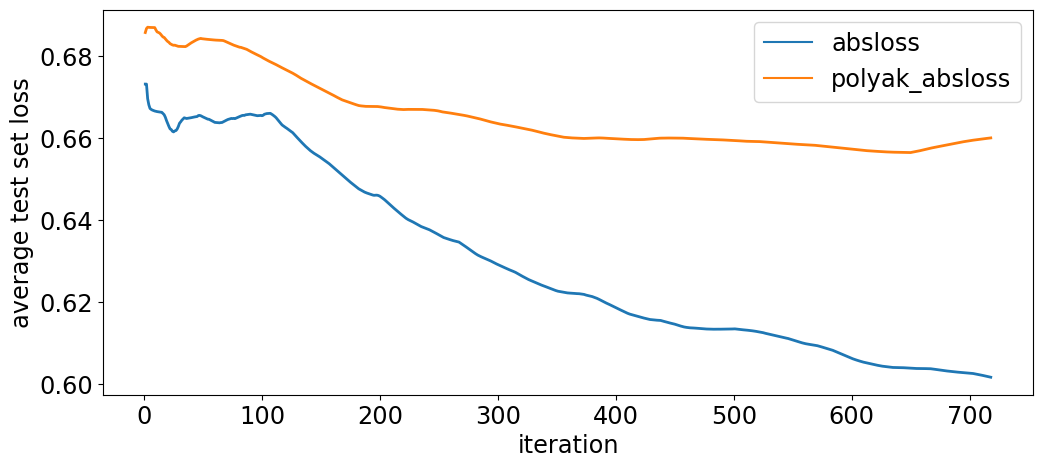

In [51]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig(f"figure_7b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

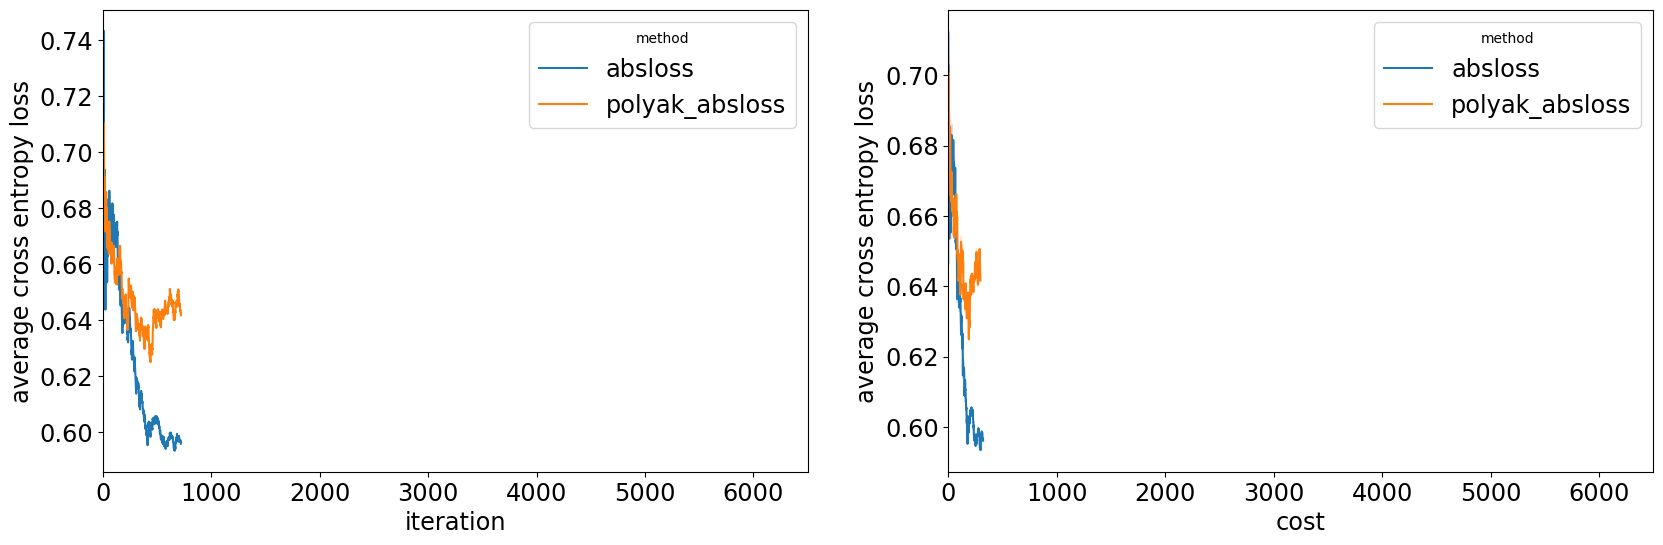

In [52]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

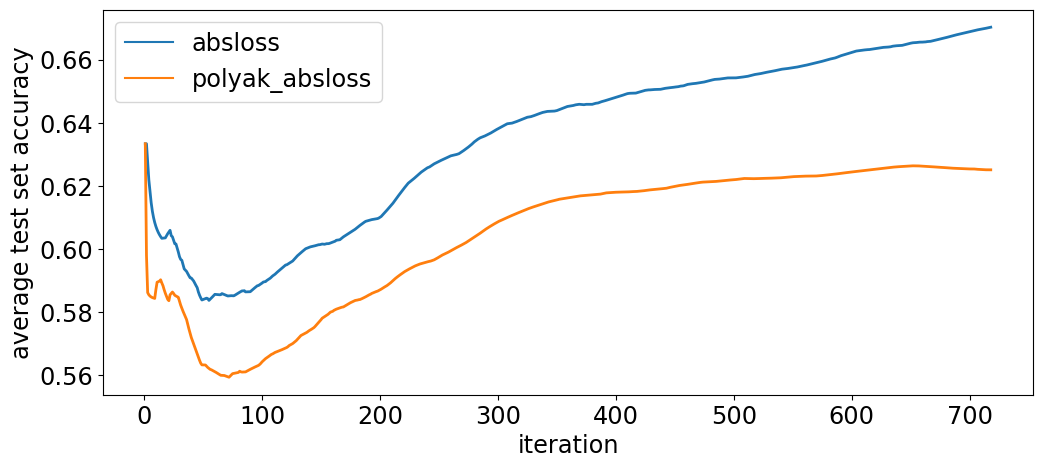

In [53]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_8b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

In [54]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
        "polyak_random": results_polyak_random
    }
)

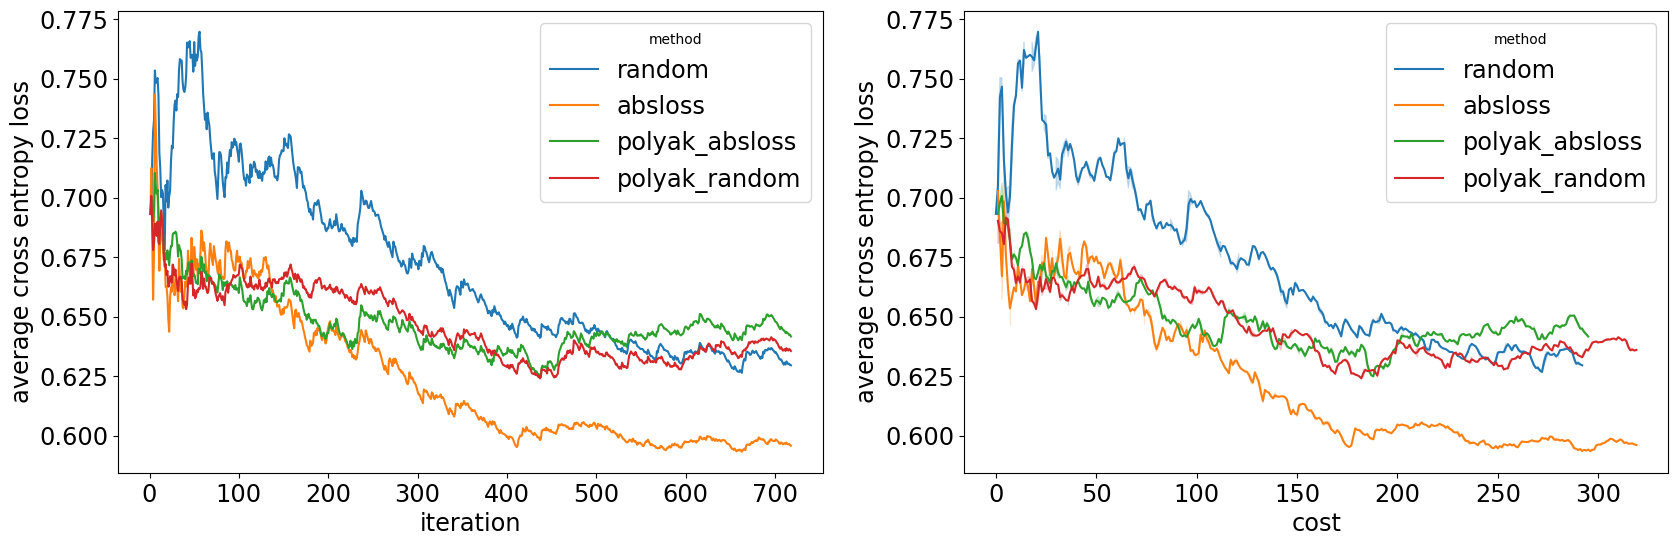

In [55]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

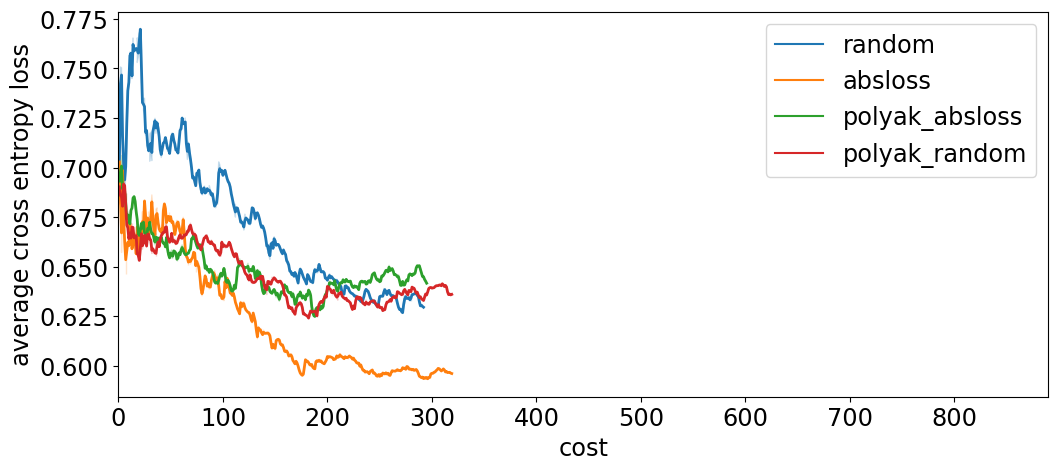

In [56]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_6_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

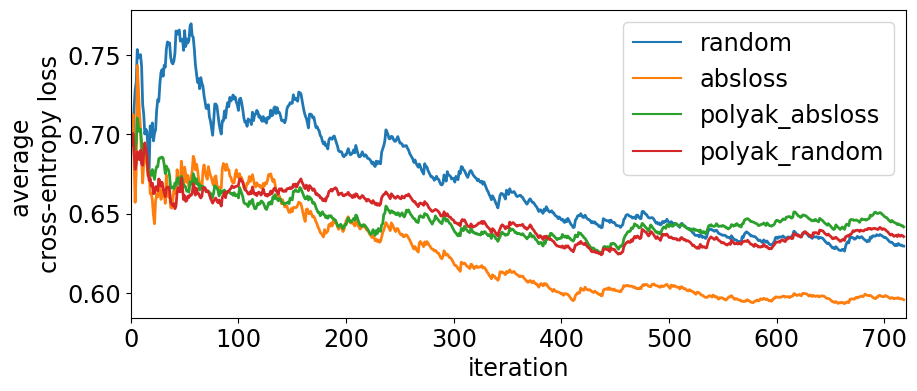

In [57]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')
ax.set_xlim((0, 720))

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig(f"figure_3_icml_{dataset_name}_9.pdf", format="pdf", bbox_inches="tight")
